In [20]:
#Libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import optuna
import joblib
import matplotlib.pyplot as plt

In [26]:
# === 1. Rutas y carga de datos ===
def get_project_root(levels=1):
    path = os.getcwd()
    for _ in range(levels):
        path = os.path.dirname(path)
    return path

# Cambia el número de niveles según tu estructura
project_root = get_project_root(levels=3)
print(f"Project root: {project_root}")
data_dir = os.path.join(project_root, "data")
data_dir = os.path.join(data_dir, "clean")
clean_csv_path = os.path.join(data_dir, "online_shoppers_clean.csv")
print(f"Data directory: {data_dir}")
print(f"Clean CSV path: {clean_csv_path}")
df = pd.read_csv(clean_csv_path)



Project root: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6
Data directory: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\data\clean
Clean CSV path: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\data\clean\online_shoppers_clean.csv


In [10]:
# === 2. Preprocesamiento ===
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['ProductRelated_Duration'] = np.log1p(df['ProductRelated_Duration'])  # log(1+x)
df['Revenue'] = df['Revenue'].astype(int)

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop("Revenue", axis=1)
y = df["Revenue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# === 3. Optuna: búsqueda de hiperparámetros ===
def objective(trial):
    params = {
        "n_estimators": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "class_weight": "balanced",
        "random_state": 42
    }
    # Aplicamos validación cruzada estratificada con StratifiedKFold
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        #Aplicamos SMOTE para balancear las clases
        smote = SMOTE(random_state=42) 
        X_res, y_res = smote.fit_resample(X_tr, y_tr)

        model = LGBMClassifier(**params)
        model.fit(X_res, y_res)
        # Predicción de probabilidades
        # Es un array de probabilidades que predice el modelo para la clase positiva (clase 1) en el conjunto de validación.
        #model.predict_proba(X_val) devuelve un array de probabilidades para cada clase (por ejemplo, [0.8, 0.2] para clases 0 y 1).
        #[:, 1] selecciona solo la probabilidad de la clase positiva (1).
        y_val_proba = model.predict_proba(X_val)[:, 1]

        best_f1 = 0 # Inicializamos el mejor F1-score en 0
        # Probamos diferentes thresholds para encontrar el mejor F1-score
        for t in np.linspace(0.3, 0.7, 15):
            y_val_pred = (y_val_proba > t).astype(int) #Es un array de predicciones binarias (0 o 1), que se obtienen aplicando un umbral (threshold) a y_val_proba.
            #Si la probabilidad es mayor al threshold, se predice clase 1.
            # Si es menor o igual, se predice clase 0.
            # Así puedes ajustar el modelo para optimizar F1-score, precisión o recall según lo que más te interese.
            f1 = f1_score(y_val, y_val_pred)
            best_f1 = max(best_f1, f1)
        f1_scores.append(best_f1)
    return np.mean(f1_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-05-08 11:52:14,838] A new study created in memory with name: no-name-4acc4d23-4902-42c5-b598-7017d77dab82


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:52:52,437] Trial 0 finished with value: 0.6682804330227161 and parameters: {'learning_rate': 0.011334473070486937, 'max_depth': 10, 'num_leaves': 78, 'min_child_samples': 43, 'subsample': 0.8593030327540065, 'colsample_bytree': 0.6621231226373661}. Best is trial 0 with value: 0.6682804330227161.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:53:04,788] Trial 1 finished with value: 0.6701945816582601 and parameters: {'learning_rate': 0.02692326999117957, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 75, 'subsample': 0.7187321769700205, 'colsample_bytree': 0.6061322554148815}. Best is trial 1 with value: 0.6701945816582601.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:53:23,805] Trial 2 finished with value: 0.6493387617751666 and parameters: {'learning_rate': 0.07038002699184726, 'max_depth': 6, 'num_leaves': 83, 'min_child_samples': 75, 'subsample': 0.7652885652510905, 'colsample_bytree': 0.6987676336715816}. Best is trial 1 with value: 0.6701945816582601.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:53:40,970] Trial 3 finished with value: 0.6707380223678263 and parameters: {'learning_rate': 0.04124514915253142, 'max_depth': 4, 'num_leaves': 140, 'min_child_samples': 78, 'subsample': 0.939950100490542, 'colsample_bytree': 0.7302113924009334}. Best is trial 3 with value: 0.6707380223678263.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:54:05,313] Trial 4 finished with value: 0.6630343276451708 and parameters: {'learning_rate': 0.031303473747635445, 'max_depth': 7, 'num_leaves': 80, 'min_child_samples': 42, 'subsample': 0.5097173910258895, 'colsample_bytree': 0.5154677862622381}. Best is trial 3 with value: 0.6707380223678263.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:54:17,991] Trial 5 finished with value: 0.6486183962015496 and parameters: {'learning_rate': 0.16721320531770817, 'max_depth': 5, 'num_leaves': 131, 'min_child_samples': 38, 'subsample': 0.9356073073061619, 'colsample_bytree': 0.8823480767814662}. Best is trial 3 with value: 0.6707380223678263.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:54:29,507] Trial 6 finished with value: 0.6455491722518932 and parameters: {'learning_rate': 0.17654234203716299, 'max_depth': 6, 'num_leaves': 96, 'min_child_samples': 63, 'subsample': 0.8584855338964874, 'colsample_bytree': 0.502203296154473}. Best is trial 3 with value: 0.6707380223678263.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:54:47,078] Trial 7 finished with value: 0.6502058051685093 and parameters: {'learning_rate': 0.07094361481661988, 'max_depth': 7, 'num_leaves': 127, 'min_child_samples': 63, 'subsample': 0.6801593681395488, 'colsample_bytree': 0.5354901108577201}. Best is trial 3 with value: 0.6707380223678263.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:54:58,074] Trial 8 finished with value: 0.6730604860644723 and parameters: {'learning_rate': 0.026152619497211316, 'max_depth': 3, 'num_leaves': 117, 'min_child_samples': 92, 'subsample': 0.5924464524288587, 'colsample_bytree': 0.6707672085259717}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:55:09,074] Trial 9 finished with value: 0.6674535785648009 and parameters: {'learning_rate': 0.07537608914720205, 'max_depth': 4, 'num_leaves': 51, 'min_child_samples': 98, 'subsample': 0.998790467111888, 'colsample_bytree': 0.5927578373317512}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:55:37,921] Trial 10 finished with value: 0.6607112186285541 and parameters: {'learning_rate': 0.019884371408530364, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 11, 'subsample': 0.5257117139205716, 'colsample_bytree': 0.8439845203971273}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:55:46,743] Trial 11 finished with value: 0.6686903152878414 and parameters: {'learning_rate': 0.04491732241440287, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 96, 'subsample': 0.6313077018175349, 'colsample_bytree': 0.7852060678511361}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:55:59,269] Trial 12 finished with value: 0.672248658718941 and parameters: {'learning_rate': 0.012408717336589803, 'max_depth': 4, 'num_leaves': 150, 'min_child_samples': 81, 'subsample': 0.6159888084069705, 'colsample_bytree': 0.9965182960867205}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:56:10,545] Trial 13 finished with value: 0.6713203042326853 and parameters: {'learning_rate': 0.010442722379325208, 'max_depth': 4, 'num_leaves': 113, 'min_child_samples': 87, 'subsample': 0.6009897206159703, 'colsample_bytree': 0.9940371244232602}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:56:17,895] Trial 14 finished with value: 0.67165719920458 and parameters: {'learning_rate': 0.015372463045761618, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 86, 'subsample': 0.5845466826437444, 'colsample_bytree': 0.990239022707948}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:56:30,458] Trial 15 finished with value: 0.6680124620343575 and parameters: {'learning_rate': 0.01822227614971138, 'max_depth': 5, 'num_leaves': 150, 'min_child_samples': 62, 'subsample': 0.66858587662086, 'colsample_bytree': 0.9146265582486701}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:57:18,730] Trial 16 finished with value: 0.665483816441954 and parameters: {'learning_rate': 0.01465109717389827, 'max_depth': 8, 'num_leaves': 98, 'min_child_samples': 19, 'subsample': 0.5679326578174719, 'colsample_bytree': 0.7861169274226394}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:57:41,253] Trial 17 finished with value: 0.6680790355302172 and parameters: {'learning_rate': 0.02466356096031558, 'max_depth': 5, 'num_leaves': 133, 'min_child_samples': 88, 'subsample': 0.7664893407615351, 'colsample_bytree': 0.6659818796662532}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:57:57,898] Trial 18 finished with value: 0.6666148601829581 and parameters: {'learning_rate': 0.03996901438381845, 'max_depth': 4, 'num_leaves': 62, 'min_child_samples': 99, 'subsample': 0.665640883663218, 'colsample_bytree': 0.8105949744728915}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:58:11,486] Trial 19 finished with value: 0.6706491137062733 and parameters: {'learning_rate': 0.013074938120162588, 'max_depth': 3, 'num_leaves': 102, 'min_child_samples': 51, 'subsample': 0.7246256170476222, 'colsample_bytree': 0.9403641251001236}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:58:34,509] Trial 20 finished with value: 0.668710100269334 and parameters: {'learning_rate': 0.021080640067899104, 'max_depth': 5, 'num_leaves': 123, 'min_child_samples': 30, 'subsample': 0.8075283738540633, 'colsample_bytree': 0.608916216465153}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:58:45,857] Trial 21 finished with value: 0.6709342645378674 and parameters: {'learning_rate': 0.015650860423351242, 'max_depth': 3, 'num_leaves': 117, 'min_child_samples': 86, 'subsample': 0.5706357796281335, 'colsample_bytree': 0.9856834698576981}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:59:07,384] Trial 22 finished with value: 0.6699031744915214 and parameters: {'learning_rate': 0.016732579103584555, 'max_depth': 3, 'num_leaves': 146, 'min_child_samples': 80, 'subsample': 0.6130287498716778, 'colsample_bytree': 0.9476172420836249}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:59:17,758] Trial 23 finished with value: 0.671297308327825 and parameters: {'learning_rate': 0.010549009292220565, 'max_depth': 4, 'num_leaves': 137, 'min_child_samples': 71, 'subsample': 0.5475025333707148, 'colsample_bytree': 0.8817276214795844}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:59:24,894] Trial 24 finished with value: 0.6696691418255275 and parameters: {'learning_rate': 0.03163424580374861, 'max_depth': 3, 'num_leaves': 105, 'min_child_samples': 90, 'subsample': 0.6312110280333088, 'colsample_bytree': 0.9674421537217445}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 11:59:32,446] Trial 25 finished with value: 0.6705861286906337 and parameters: {'learning_rate': 0.013909442469259087, 'max_depth': 4, 'num_leaves': 121, 'min_child_samples': 83, 'subsample': 0.5863259274643762, 'colsample_bytree': 0.8971170805764427}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:59:48,825] Trial 26 finished with value: 0.6631552987502272 and parameters: {'learning_rate': 0.022664956790153595, 'max_depth': 6, 'num_leaves': 96, 'min_child_samples': 56, 'subsample': 0.5005149702275389, 'colsample_bytree': 0.8345490354910466}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 11:59:56,733] Trial 27 finished with value: 0.6664322881106578 and parameters: {'learning_rate': 0.054892559746099946, 'max_depth': 3, 'num_leaves': 71, 'min_child_samples': 71, 'subsample': 0.6505272833771556, 'colsample_bytree': 0.7320424154384374}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-08 12:00:08,834] Trial 28 finished with value: 0.6600011233987042 and parameters: {'learning_rate': 0.02939675743510787, 'max_depth': 5, 'num_leaves': 90, 'min_child_samples': 94, 'subsample': 0.549635774776801, 'colsample_bytree': 0.9236061324001535}. Best is trial 8 with value: 0.6730604860644723.


[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2025-05-08 12:00:21,082] Trial 29 finished with value: 0.6741588488836182 and parameters: {'learning_rate': 0.012346469174854657, 'max_depth': 4, 'num_leaves': 138, 'min_child_samples': 70, 'subsample': 0.7102351212910533, 'colsample_bytree': 0.6517506359655352}. Best is trial 29 with value: 0.6741588488836182.


In [12]:
# === 4. Guardar el estudio ===
joblib.dump(study, "optuna_study.pkl")
print("📁 Estudio guardado en 'optuna_study.pkl'")

best_params = study.best_params
best_params.update({"n_estimators": 500, "class_weight": "balanced", "random_state": 42})
print("\n🎯 Mejores hiperparámetros encontrados:")
print(best_params)

📁 Estudio guardado en 'optuna_study.pkl'

🎯 Mejores hiperparámetros encontrados:
{'learning_rate': 0.012346469174854657, 'max_depth': 4, 'num_leaves': 138, 'min_child_samples': 70, 'subsample': 0.7102351212910533, 'colsample_bytree': 0.6517506359655352, 'n_estimators': 500, 'class_weight': 'balanced', 'random_state': 42}


In [13]:
# === 5. Entrenamiento final ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 8238, number of negative: 8238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 16476, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6517506359655352,
               learning_rate=0.012346469174854657, max_depth=4,
               min_child_samples=70, n_estimators=500, num_leaves=138,
               random_state=42, subsample=0.7102351212910533)

In [14]:
# === 6. Guardar modelo entrenado ===
joblib.dump(final_model, "lightgbm_model.pkl")
print("📁 Modelo LightGBM guardado en 'lightgbm_model.pkl'")

📁 Modelo LightGBM guardado en 'lightgbm_model.pkl'


In [15]:
# === 7. Buscar mejor threshold ===
y_val_proba = final_model.predict_proba(X_train)[:, 1]
best_f1 = 0
best_threshold = 0.5
for t in np.linspace(0.3, 0.7, 50):
    y_val_pred = (y_val_proba > t).astype(int)
    f1 = f1_score(y_train, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔍 Mejor threshold encontrado: {best_threshold:.3f}")



🔍 Mejor threshold encontrado: 0.692


In [16]:
# === 8. Evaluación en test ===
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > best_threshold).astype(int)

print("\n📊 Evaluación en test:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))


📊 Evaluación en test:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2059
           1       0.66      0.70      0.68       382

    accuracy                           0.90      2441
   macro avg       0.80      0.82      0.81      2441
weighted avg       0.90      0.90      0.90      2441

Confusion Matrix:
 [[1920  139]
 [ 115  267]]
ROC-AUC: 0.9276207888239347


In [17]:
# === 9. Evaluación en entrenamiento para medir overfitting ===
y_train_proba = final_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba > best_threshold).astype(int)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n📈 F1-score entrenamiento: {train_f1:.4f}")
print(f"📉 F1-score test:          {test_f1:.4f}")
print(f"⚠️ Overfitting (train - test): {train_f1 - test_f1:.4f}")


📈 F1-score entrenamiento: 0.6974
📉 F1-score test:          0.6777
⚠️ Overfitting (train - test): 0.0197


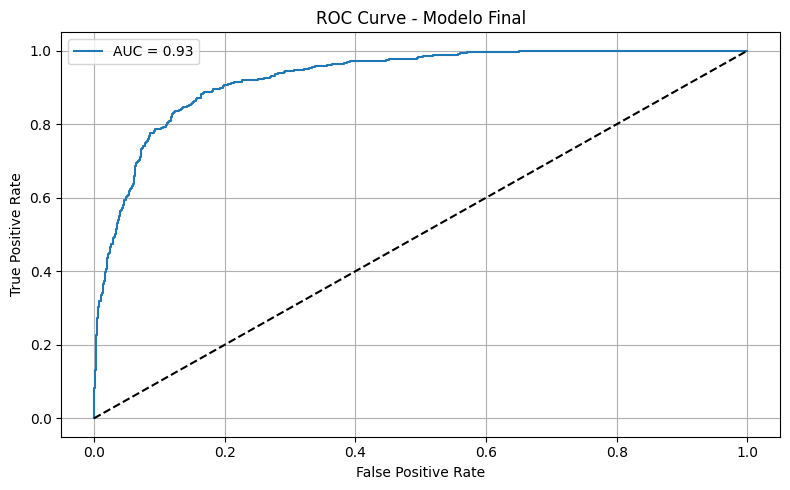

In [18]:
# === 10. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Modelo Final")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

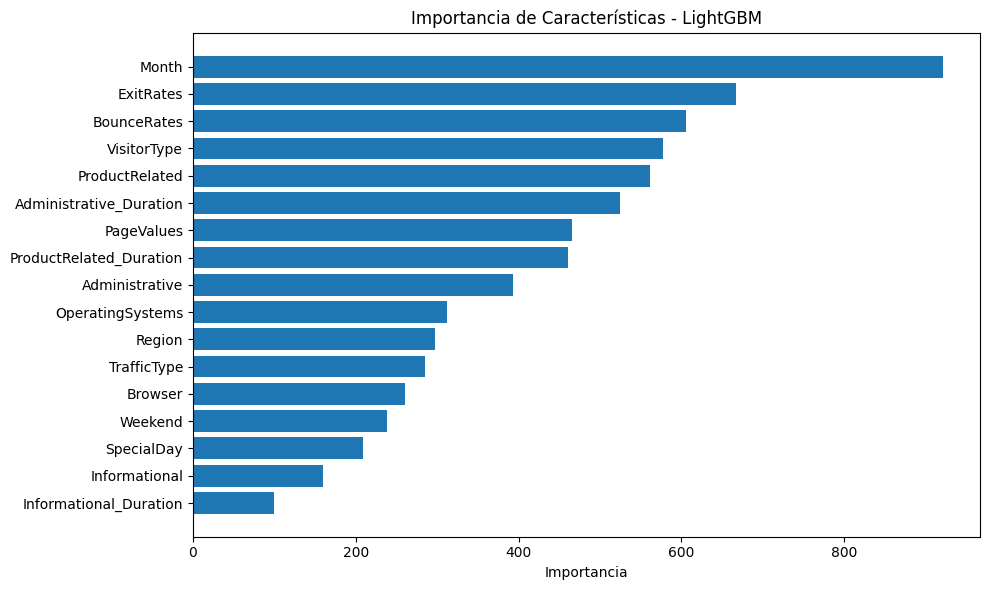

In [22]:
# === 11. Importancia de características ===
importances = final_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de Características - LightGBM")
plt.tight_layout()
plt.show()